<a href="https://colab.research.google.com/github/kavyajeetbora/CityHealthMonitor/blob/master/development/urban_heat_island_index.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Urban Heat Island Index

![](https://images.ctfassets.net/cxgxgstp8r5d/cm-graphic-uhi-temperature-infographic/d4fed0e376f09424dae5c880d97e2239/2021UHI_TempProfile_en_title_lg.jpg?w=1920)



## Install and import external packages

In [1]:
!pip install -q rioxarray
!pip install -q h3
!pip install -q pydeck

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.5/60.5 kB 696.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 33.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 21.9 MB/s eta 0:00:00


In [2]:
import geemap
import ee
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd
import geopandas as gpd
import rioxarray
from shapely.geometry import Polygon, Point
import h3
from matplotlib import colormaps
import pydeck as pdk

ee.Authenticate()
ee.Initialize(project='kavyajeetbora-ee')

## Utility Functions

- Create a standard function to apply filters on image collection

In [64]:
def filterImageCollection(
        image_collection_id: str,
        geometry: ee.geometry.Geometry,
        date_range: tuple[str]
    ) -> ee.imagecollection.ImageCollection:

    imageCollection = ee.ImageCollection(image_collection_id)
    d1,d2 = date_range
    filtered = imageCollection.filter(
        ee.Filter.date(d1, d2) ## Filter by date
    ).filter(
        ee.Filter.bounds(geometry) ## Filter by bounds
    )

    return filtered

def summarizeRegion(image, geometry, bandName, reducer_name='mean'):
    '''
    Compute the average regional stat of a given image
    and store it in image property metadata
    '''

    if reducer_name == 'mean':
        reducer = ee.Reducer.mean()
    elif reducer_name == 'std':
        reducer = ee.Reducer.stdDev()
    else:
        reducer_name = None

    if reducer is not None:
        stat = ee.Number(image.reduceRegion(
            reducer = reducer,
            geometry = geometry,
            scale = 1000, ## scale = 10 m pixel, gee will down/up sample the image as required
            maxPixels = 1e10
        ).get(bandName))

        return image.set(reducer_name, stat)

    else:
        print("Invalid Reducer Name")

def kelvin_to_celsius(image):
    temp = image.multiply(0.02).subtract(273.15).rename('temp_C')
    return image.addBands(temp).copyProperties(image, ['system:time_start'])

In [4]:
## get the current dates
today = datetime.now()
d1 = today - timedelta(days=30)
current_date_range = (d1.date().strftime('%Y-%m-%d'), today.date().strftime('%Y-%m-%d'))
current_date_range

('2024-03-31', '2024-04-30')

## Visualizing satellite RGB image

In [5]:
admin = ee.FeatureCollection('FAO/GAUL_SIMPLIFIED_500m/2015/level2')
delhi = admin.filter(ee.Filter.eq('ADM1_NAME', 'Delhi'))\
.filter(ee.Filter.eq('ADM2_NAME', 'Delhi'))

geometry = delhi.geometry()

filtered_imgs = filterImageCollection(
    image_collection_id = 'COPERNICUS/S2_SR_HARMONIZED',
    geometry = geometry,
    date_range = current_date_range
)

In [6]:
image = filtered_imgs.median()
clipped_img = image.clip(geometry)

center = (28.6182,77.2009)
Map = geemap.Map(center=center, zoom=10)
boundary_viz_params = {
    'color':'red',
    "width":2,
    "lineType":"solid",
    'fillColorOpacity': 0.1
}
Map.addLayer(ee_object=delhi, vis_params=boundary_viz_params, name='Delhi Boundary')
viz_params = {
    'min': 0,
    'max': 3000,
    'bands': ['B4', "B3", "B2"]
}
Map.addLayer(clipped_img, viz_params, name='Sentinel')
Map

Map(center=[28.6182, 77.2009], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDa…

## Visualizing the surface temperature data

In [7]:
## Filtered_image_Collection
surface_temp = filterImageCollection(
        image_collection_id = "MODIS/061/MOD11A1",
        geometry = geometry,
        date_range = current_date_range
    )\
    .select('LST_Day_1km')\
    .map(kelvin_to_celsius)

surface_temp.size()

## Calculate the median composite of surface temperature for plotting

Calculate the urban heat island:

UHI $= \frac{(LST - LST_m)}{LST_std}$

for calculating the urban heat island we require two indices mean and standard deviation reduced over region

In [57]:
temp_median = surface_temp.median().clip(geometry)
## Calculate the urban heat island index
temp_UHI = summarizeRegion(temp_median, geometry, bandName='temp_C', reducer_name='mean')
temp_UHI = summarizeRegion(temp_UHI, geometry, bandName='temp_C', reducer_name='std')

mean, std = temp_UHI.getInfo()['properties']['mean'], temp_UHI.getInfo()['properties']['std']

UHI = temp_UHI.select('temp_C').subtract(mean).divide(std)
UHI

In [61]:
center = (28.6182,77.2009)
Map = geemap.Map(center=center, zoom=10)
viz_params = {
    'min': 1,
    'max': 3,
    'bands': ['temp_C'],
    'palette': ['#ffffb2','#fecc5c','#fd8d3c','#f03b20','#bd0026']
}
Map.addLayer(UHI, viz_params, name='Urban Heat Island')
Map

Map(center=[28.6182, 77.2009], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDa…

## Export the data

Export the surface temperature raster image:

In [65]:
UHI.bandNames()

In [67]:
geemap.ee_export_image(
    UHI.clip(geometry),
    filename='urban_heat_island.tif',
    scale=100,
    file_per_band=False,
    region=geometry,
)

Generating URL ...
Please wait ...
Data downloaded to /content/urban_heat_island.tif


## Converting the raster to xyz point data


In [68]:
xds = rioxarray.open_rasterio('urban_heat_island.tif')\
        .sel(band=1)\
        .to_pandas()

xds = (xds).stack().reset_index().rename(columns={"x": 'lng', 'y': 'lat', 0: 'UHI'})
print(xds.shape)
xds.head()

(299484, 3)


,lat,lng,UHI
0,28.884879,76.831559,0.0
1,28.884879,76.832457,0.0
2,28.884879,76.833355,0.0
3,28.884879,76.834254,0.0
4,28.884879,76.835152,0.0


## Clip the dataframe within the polygon

- First extract the coordinates of the `google earth engine Geometry object`
- Then convert the coordinates to a `shapely.geometry.Polygon`
- Use this geomtry to filter out the h3 spatial index from the dataframe

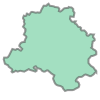

In [71]:
delhi_geom = Polygon(geometry.getInfo()['coordinates'][0])
delhi_geom

In [72]:
xds['geometry'] = list(map(Point, zip(xds['lng'], xds['lat'])))
gdf = gpd.GeoDataFrame(xds, crs='EPSG:4326', geometry='geometry')
print(f"Total of {gdf.shape[0]} points are in the dataset")
gdf.sample(2)

Total of 299484 points are in the dataset


,lat,lng,UHI,geometry
108669,28.712402,77.173817,-0.091730,POINT (77.17382 28.71240)
187745,28.586638,77.278021,-1.975231,POINT (77.27802 28.58664)


In [73]:
gdf = gdf[gdf['geometry'].within(delhi_geom)]
print(f"After clipping the points, now {gdf.shape[0]} points remain in the dataset")

After clipping the points, now 171810 points remain in the dataset


## Converting to H3 spatial index

We have now temperature for each coordinate. We need to convert them to h3 spatial index for visualization

**why visualizing the data with h3 spatial index ?**

- Better compatibility with other visualization tools
- Faster visualization
- requires less space to store the data
- Performance and Scalability: H3 is designed for scalability and performance, making it suitable for real-time or dynamic visualizations of large-scale geospatial datasets

In [74]:
APERTURE_SIZE = 8
hex_col = 'hex'+str(APERTURE_SIZE)
hex_col

'hex8'

In [75]:
gdf.shape

(171810, 4)

In [77]:
# find hexs containing the points
gdf[hex_col] = gdf.apply(lambda x: h3.geo_to_h3(x.lat,x.lng,APERTURE_SIZE),1)
gdf.sample(5)

,lat,lng,UHI,geometry,hex8
183092,28.593825,77.151359,-1.248738,POINT (77.15136 28.59382),883da11721fffff
204426,28.559689,77.063324,0.540588,POINT (77.06332 28.55969),883da11003fffff
108267,28.713301,77.319344,1.455432,POINT (77.31934 28.71330),883da1ab59fffff
231099,28.517468,77.211546,-1.369820,POINT (77.21155 28.51747),883da102e3fffff
112376,28.706114,76.957323,0.251336,POINT (76.95732 28.70611),883da18a95fffff


In [78]:
# calculate temperature average per hex
temp_hex_data = gdf.groupby(hex_col)['UHI'].mean().to_frame('UHI').reset_index()
temp_hex_data.sample(5)

,hex8,UHI
60,883da100d3fffff,-0.241698
323,883da11001fffff,0.301053
1909,883da1b9c5fffff,0.087651
513,883da11255fffff,0.494351
24,883da10037fffff,0.530537


In [79]:
temp_hex_data.shape

(2100, 2)

After creating the hexagons using the h3 spatial index, the point data are reduced to 3545 from 299484.This saves a significant amount of disk space.

Also compared to geometries which are mostly having coordinates with float numbers, it is more efficient to store a h3 index as it is a string object with fixed number of characters (15-16 characters)

To view the h3 spatial indices, check out this [Uber h3 viewer](https://wolf-h3-viewer.glitch.me/)

## Visualizing the results in pydeck

for visualizing the surface temperature data, we will first format the data


- Normalizing the temperature values
- then color coding the temperature values using a colormap
- splitting the colormap values to make it compatible with pydeck `get_fill_color` attribute
- Formatting a tooltip for interactive data visualization

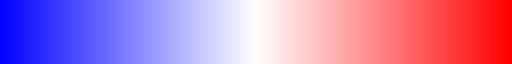

In [80]:
def color_code_value(value, cmap):
    color = cmap(value)
    scaled_colors = list(map(lambda x: int(x*255), color[:3]))
    scaled_alpha = int(color[3]*100)

    scaled_colors += [scaled_alpha]
    return scaled_colors

## Choose a colormap
cmap = colormaps['bwr']
cmap

In [81]:
xdf = temp_hex_data.copy()

## Scale the temperature values between 0-1; using MinMax Scaler
xdf['UHI_norm'] = (xdf['UHI']-xdf['UHI'].min())/(xdf['UHI'].max()-xdf['UHI'].min())
xdf['color'] = xdf['UHI_norm'].apply(lambda x: color_code_value(x, cmap))
xdf[['R', 'G', 'B', 'A']] = pd.DataFrame(xdf['color'].to_list())
xdf = xdf.drop(['color', 'UHI_norm'], axis=1)

## formatting the temperature value upto 1 decimal place
xdf['UHI'] = xdf['UHI'].round(1)

xdf.sample(4)

,hex8,UHI,R,G,B,A
147,883da10249fffff,0.3,252,252,255,100
1134,883da184bbfffff,-1.0,136,136,255,100
1992,883da1bb5bfffff,-1.0,130,130,255,100
855,883da11657fffff,-0.3,194,194,255,100


In [82]:
xdf['UHI'].describe()

count    2100.000000
mean        0.004762
std         0.946821
min        -2.500000
25%        -0.600000
50%         0.000000
75%         0.600000
max         3.200000
Name: UHI, dtype: float64

Generating the tooltip:

In [86]:
tooltip = {
        "html": "<b>Urban Heat Island Index</b>: {UHI}",
        "style": {
            "backgroundColor": "#4CAF50",   # Green shade for background
            "color": "#FFFFFF",             # White for text color
            "border": "2px solid #4CAF50",  # Matching border color
            "borderRadius": "5px",          # Rounded corners
            "boxShadow": "2px 2px 10px rgba(0, 0, 0, 0.2)"  # Soft shadow effect
        }
    }

Finally plotting the results on a 3D map

In [87]:
# Define a layer to display on a map
layer = pdk.Layer(
    "H3HexagonLayer",
    xdf,
    pickable=True,
    stroked=True,
    filled=True,
    extruded=False,
    get_hexagon=hex_col,
    get_fill_color="[R, G, B, A]"
)

# Set the viewport location
view_state = pdk.ViewState(latitude=28.664, longitude=77.1062, zoom=11, bearing=0, pitch=30)

# Render
r = pdk.Deck(layers=[layer], initial_view_state=view_state, tooltip = tooltip)
r

<IPython.core.display.Javascript object>

{
  "initialViewState": {
    "bearing": 0,
    "latitude": 28.664,
    "longitude": 77.1062,
    "pitch": 30,
    "zoom": 11
  },
  "layers": [
    {
      "@@type": "H3HexagonLayer",
      "data": [
        {
          "A": 100,
          "B": 255,
          "G": 227,
          "R": 227,
          "UHI": 0.1,
          "hex8": "883da10001fffff"
        },
        {
          "A": 100,
          "B": 255,
          "G": 246,
          "R": 246,
          "UHI": 0.3,
          "hex8": "883da10003fffff"
        },
        {
          "A": 100,
          "B": 234,
          "G": 234,
          "R": 255,
          "UHI": 0.6,
          "hex8": "883da10005fffff"
        },
        {
          "A": 100,
          "B": 232,
          "G": 232,
          "R": 255,
          "UHI": 0.6,
          "hex8": "883da10007fffff"
        },
        {
          "A": 100,
          "B": 255,
          "G": 198,
          "R": 198,
          "UHI": -0.3,
          "hex8": "883da10009fffff"
        },
        {
          "A": 100,
          "B": 255,
          "G": 170,
          "R": 170,
          "UHI": -0.6,
          "hex8": "883da1000bfffff"
        },
        {
          "A": 100,
          "B": 255,
          "G": 248,
          "R": 248,
          "UHI": 0.3,
          "hex8": "883da1000dfffff"
        },
        {
          "A": 100,
          "B": 255,
          "G": 216,
          "R": 216,
          "UHI": -0.1,
          "hex8": "883da10011fffff"
        },
        {
          "A": 100,
          "B": 255,
          "G": 200,
          "R": 200,
          "UHI": -0.2,
          "hex8": "883da10013fffff"
        },
        {
          "A": 100,
          "B": 255,
          "G": 222,
          "R": 222,
          "UHI": -0.0,
          "hex8": "883da10015fffff"
        },
        {
          "A": 100,
          "B": 255,
          "G": 208,
          "R": 208,
          "UHI": -0.2,
          "hex8": "883da10017fffff"
        },
        {
          "A": 100,
          "B": 255,
          "G": 198,
          "R": 198,
          "UHI": -0.3,
          "hex8": "883da10019fffff"
        },
        {
          "A": 100,
          "B": 255,
          "G": 192,
          "R": 192,
          "UHI": -0.4,
          "hex8": "883da1001bfffff"
        },
        {
          "A": 100,
          "B": 255,
          "G": 234,
          "R": 234,
          "UHI": 0.1,
          "hex8": "883da1001dfffff"
        },
        {
          "A": 100,
          "B": 206,
          "G": 206,
          "R": 255,
          "UHI": 0.9,
          "hex8": "883da10021fffff"
        },
        {
          "A": 100,
          "B": 240,
          "G": 240,
          "R": 255,
          "UHI": 0.5,
          "hex8": "883da10023fffff"
        },
        {
          "A": 100,
          "B": 214,
          "G": 214,
          "R": 255,
          "UHI": 0.8,
          "hex8": "883da10025fffff"
        },
        {
          "A": 100,
          "B": 228,
          "G": 228,
          "R": 255,
          "UHI": 0.7,
          "hex8": "883da10027fffff"
        },
        {
          "A": 100,
          "B": 224,
          "G": 224,
          "R": 255,
          "UHI": 0.7,
          "hex8": "883da10029fffff"
        },
        {
          "A": 100,
          "B": 214,
          "G": 214,
          "R": 255,
          "UHI": 0.8,
          "hex8": "883da1002bfffff"
        },
        {
          "A": 100,
          "B": 228,
          "G": 228,
          "R": 255,
          "UHI": 0.7,
          "hex8": "883da1002dfffff"
        },
        {
          "A": 100,
          "B": 255,
          "G": 246,
          "R": 246,
          "UHI": 0.3,
          "hex8": "883da10031fffff"
        },
        {
          "A": 100,
          "B": 255,
          "G": 234,
          "R": 234,
          "UHI": 0.1,
          "hex8": "883da10033fffff"
        },
        {
          "A": 100,
          "B": 248,
          "G": 248,
          "R": 255,
          "UHI": 0.4,
          "hex8": "883

## Reference

1. [Create a choropleth map using h3 and plotly](https://medium.com/@ransaka/how-to-create-a-choropleth-map-using-uber-h3-plotly-python-c65555744c87)

2. [Uber h3 py notebook](https://github.com/uber/h3-py-notebooks/blob/master/notebooks/unified_data_layers.ipynb)

3. [All available matplotlib colormaps for plotting](https://matplotlib.org/stable/users/explain/colors/colormaps.html)